In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob

from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

import warnings
warnings.filterwarnings("ignore")

### Missing value handling

In [2]:
# path of the training directory
TRAIN_DIR = r"data"

Approach 1<br><br>
 We try by imputing the mean/mode of surrounding pixels which are empty. In case all surrounding pixels are empty we impute the mean/mode of the image. To avoid dealing separately with edge and crner pixels, we pad the image with nans and ignore nan's while taking mean

In [3]:
# For filling empty/NaN values we try mean imputation with surrounding pixels
from scipy.stats import mode

def pad(arr,d):
    """ Provides a padding of NaN's to an image 

    arr: image array
    d: depth of padding
    returns: padded image
    """
    n = arr.shape[0]

    arr_padded = np.full(shape=(n+2*d,n+2*d),fill_value=np.nan)
    arr_padded[d:n+d,d:n+d] = arr
    return arr_padded

def fill_cell(arr,i,j, deg, default_value):
    """ Function to impute a single pixel

    arr: image array
    i, j: position of the cell to be imputed
    deg: degree of neighbours to be taken into account
    default_value: default value to impute if all neighbors are NaN's

    """
    
    # ignores nan value while taking mean
    mean_val = np.nanmean(arr[i-deg:i+deg+1, j-deg:j+deg+1])
    if np.isnan(mean_val):
        arr[i][j] = default_value
    else:
        arr[i][j] = mean_val

def fill_nan(img, deg, method="mean", value=None):
    """ Performs imputation of a given image with neighboring pixels
    
    img: array of given image
    deg: degree of neighboring pixels to consider while imputing
    method: method of imputing if all neighboring pixels are NaN's
    value: in case no method is specified, default value to impute
    """
    
    if method == "mode":
        c = mode(img, axis=None)[0][0]
    elif method == "mean":
        c = np.nanmean(img)
    else:
        c = value

    n = img.shape[0]

    img2 = pad(img,deg)
    mask = np.isnan(img2)

    # loop over all the pixels
    for i in range(deg,n+deg):
        for j in range(deg,n+deg):

            # if pixel contains NaN
            if mask[i][j]:

                fill_cell(img2, i, j, deg,c)

    return img2[deg:n+deg, deg:n+deg]

Text(0.5, 1.0, 'Imputed image')

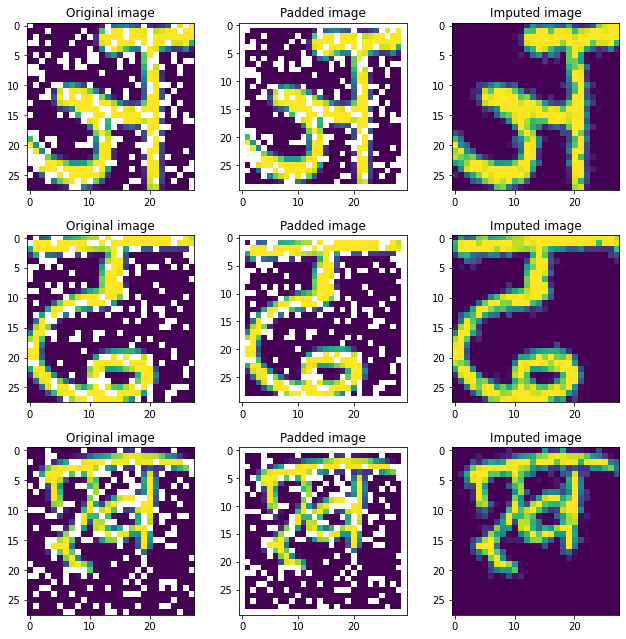

In [4]:
# Visualising the result by this approach with 3 random images
fig, axs = plt.subplots(3,3, figsize=(9,9))
plt.tight_layout()

img = np.array(pd.read_csv(os.path.join(TRAIN_DIR, r"character_0", r"1.csv"),header=None))
axs[0,0].imshow(img)
axs[0,0].set_title('Original image')
axs[0,1].imshow(pad(img, d=1))
axs[0,1].set_title('Padded image')
axs[0,2].imshow(fill_nan(img,deg=1, method="mean"))
axs[0,2].set_title('Imputed image')

img = np.array(pd.read_csv(os.path.join(TRAIN_DIR, r"character_1", r"14.csv"),header=None))
axs[1,0].imshow(img)
axs[1,0].set_title('Original image')
axs[1,1].imshow(pad(img, d=1))
axs[1,1].set_title('Padded image')
axs[1,2].imshow(fill_nan(img,deg=1, method="mean"))
axs[1,2].set_title('Imputed image')

img = np.array(pd.read_csv(os.path.join(TRAIN_DIR, r"character_8", r"14.csv"),header=None))
axs[2,0].imshow(img)
axs[2,0].set_title('Original image')
axs[2,1].imshow(pad(img, d=1))
axs[2,1].set_title('Padded image')
axs[2,2].imshow(fill_nan(img,deg=1, method="mean"))
axs[2,2].set_title('Imputed image')

In [6]:
# creates a pandas dataframe looping over each subdirectory inside the main 
# directory
def create_dataset_app1(img_dir):
    
    # list to store data for each class and labels
    data_list = []
    labels = []

    for class_dir in glob.glob(TRAIN_DIR+r"/**"):
        data_list.append(prepare_dataset(class_dir))

    data = pd.concat(data_list, axis=0)
    
    for i in range(10):
        labels.extend([i]*1000)
   
    data['labels'] = labels

    return data

In [8]:
# This step takes time
# The same dataframe is stored in lab_img_data.csv

data_1 = create_dataset_app1(TRAIN_DIR)
data_1.to_csv(r"lab_img_data.csv")

------------------------------------------------------------------------------------------------------------------

Approach 2<br><br>
We try to use imformation from other images of the same class to imoute our image. Mean/mode imputation from all images of the same class is tried out

In [9]:
def prepare_dataset(dir_path):
    """ Prepares a pandas dataframe out of all images with each image in one row

    dir_path: path of directory where images are located
    """
    
    file_list = glob.glob(dir_path+r"/*.csv")
    data = np.zeros(shape=(len(file_list),28*28))

    for i, img_path in enumerate(file_list):
        img = np.array(pd.read_csv(img_path, header=None)).reshape(1,-1)
        data[i,:] = img

    return pd.DataFrame(data)

In [15]:
# Testing out the method
# We create a dataset of images in a csv file with each image as a 28*28 = 784 sized vector

# Prepare a dataset out of all images of character_0
img_data = prepare_dataset(os.path.join(TRAIN_DIR, "character_0")) 

# we try to impute images based on test statistic from all images of that class
img_data.fillna(img_data.mean(),inplace=True) # mean imputation

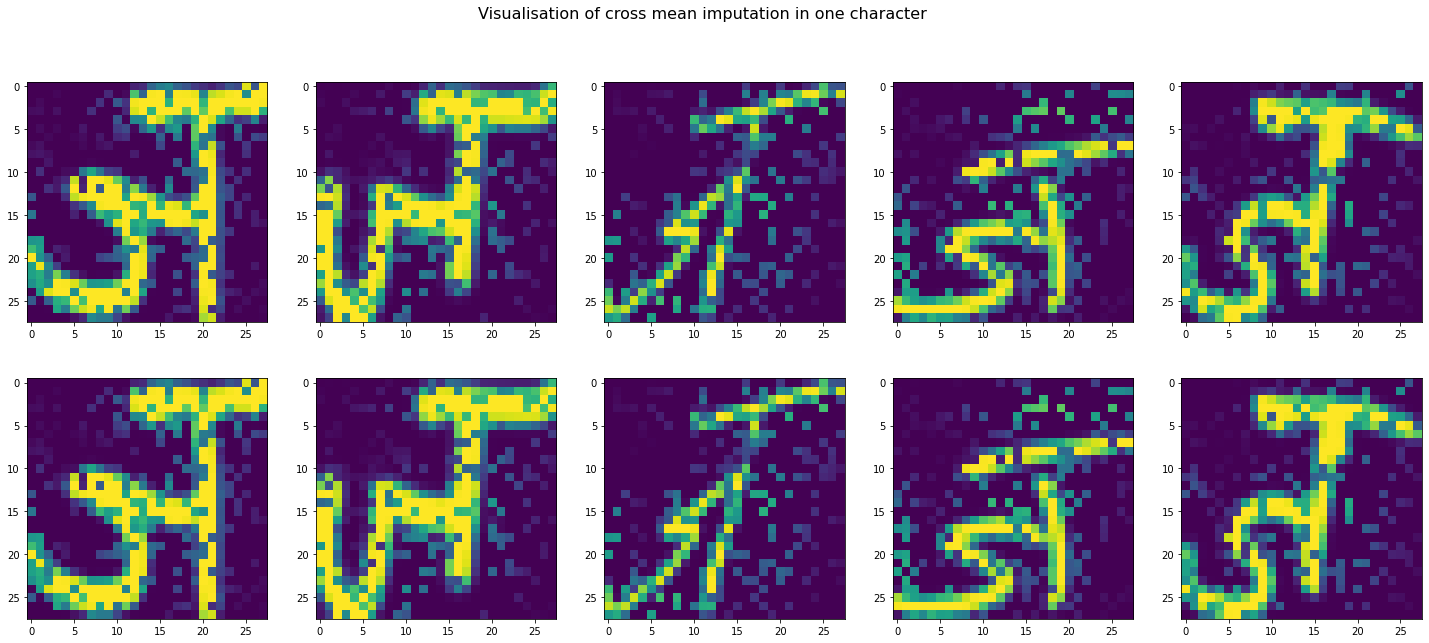

In [20]:
## Plotting to visualize the results ##
## following images are to see results only for character_0 ##
fig, axs = plt.subplots(2,5,figsize=(25,10))
fig.suptitle("Visualisation of cross mean imputation in one character", fontsize=16)
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(np.array(img_data.iloc[99*j]).reshape(28,28))

In [22]:
# We try the same process as above imputing the mode this time
# Prepare a dataset out of all images of character_0
img_data = prepare_dataset(os.path.join(TRAIN_DIR, "character_0")) 

# trying out imputation with mode
img_data.fillna(img_data.mode(dropna=True),inplace=True) # mode imputation

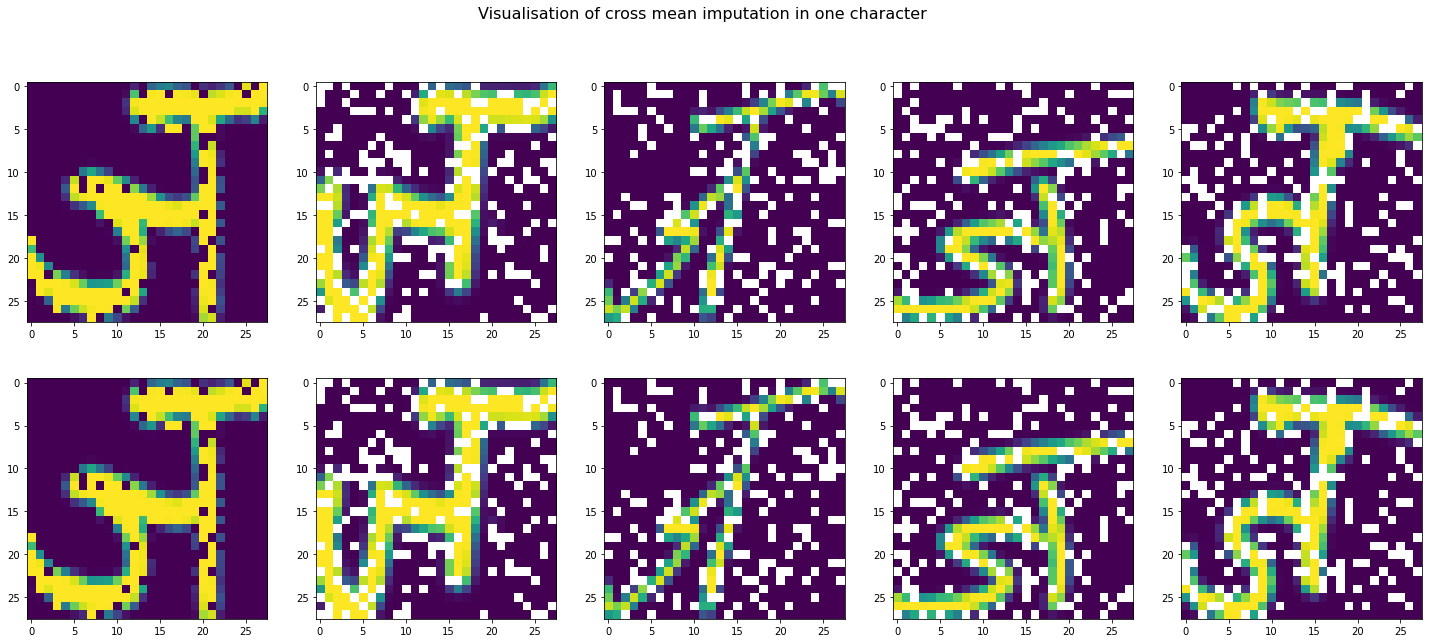

In [23]:
## Plotting to visualize the results ##
## following images are to see results only for character_0 ##
fig, axs = plt.subplots(2,5,figsize=(25,10))
fig.suptitle("Visualisation of cross mean imputation in one character", fontsize=16)
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(np.array(img_data.iloc[99*j]).reshape(28,28))

We can see that in Approach 2, mean imputing gives much noise in the background of the image whereas mode imputation results in noise inside the alphabet, also leaving the image raw when NaN is the mode of the image. So, by observation we prefer method 1.

-------------------------------------------------------------------------------------------------------------------

Approach 3: KNN imputation<br><br>

In this case we use KNN Imputer from scikit learn library which finds out the nearest neighor feature vectors of a given feature vector with NaN present and imputes it with the a statistic (mean/mode) of its nearest neighbors

In [24]:
# creates a pandas dataframe looping over each subdirectory inside the main 
# directory
def create_dataset_knn(img_dir):
    
    # list to store data for each class and labels
    data_list = []
    labels = []

    for class_dir in glob.glob(TRAIN_DIR+r"/**"):
        data_list.append(prepare_dataset(class_dir))

    data = pd.concat(data_list, axis=0)
    
    imputer = KNNImputer(n_neighbors=5)
    data = pd.DataFrame(imputer.fit_transform(data))
    
    for i in range(10):
        labels.extend([i]*1000)
   
    data['labels'] = labels

    return data

In [25]:
# This step takes time due to the size of the dataset
# This dataframe is stored as knn_imputed.csv in the folder
data_knn = create_dataset_knn(TRAIN_DIR)

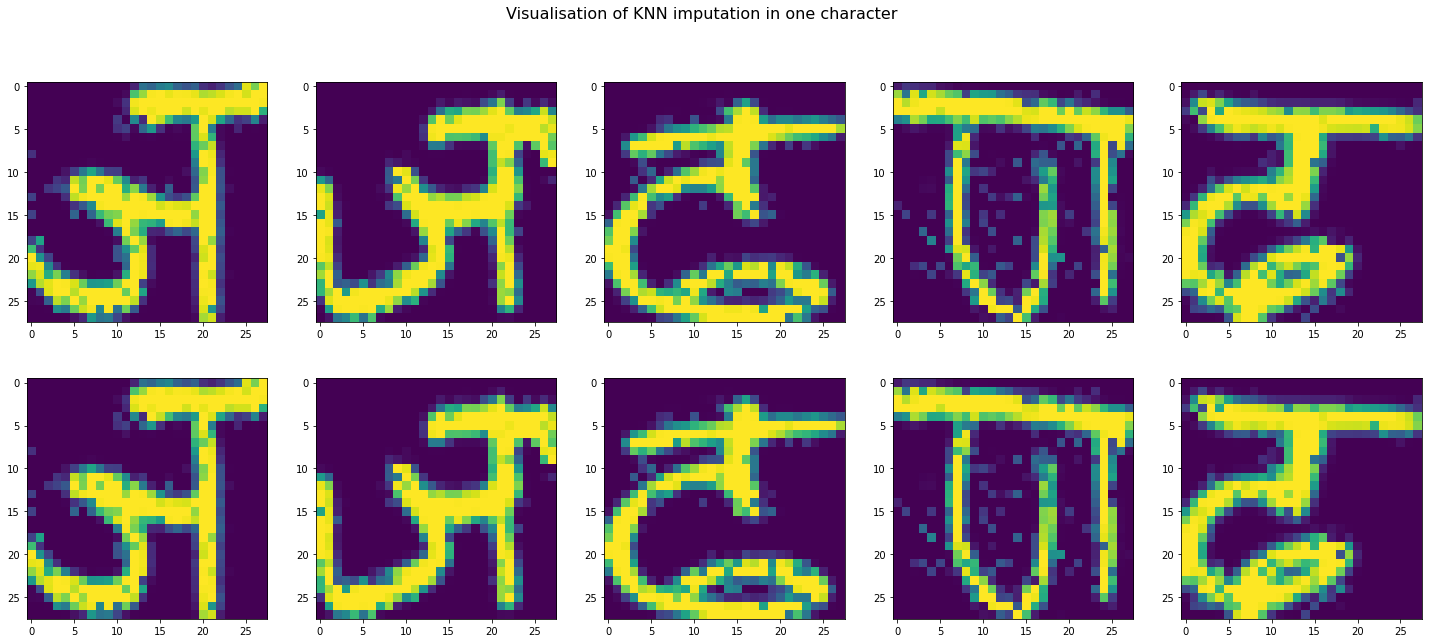

In [27]:
## Plotting to visualize the results ##
fig, axs = plt.subplots(2,5,figsize=(25,10))
fig.suptitle("Visualisation of KNN imputation in one character", fontsize=16)
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(np.array(data_knn.iloc[999*j][:-1]).reshape(28,28))

In [21]:
#loading imputed data
#train1 is the mean imputed data
train1 = pd.read_csv("lab_img_data.csv")
train1.fillna(0, inplace=True)
train1.drop(columns=[train1.columns[0]], inplace=True) # dropping 1st column containing indexes

labels = train1.pop('labels').to_numpy()
images = train1.to_numpy()
X_train1 = images.copy()                        #X_train using mean imputation
Y_train1 = labels.copy()

#train2 is the knn imputed data
train2  = pd.read_csv("knn_imputed.csv")
train2.fillna(0, inplace=True)
train2.drop(columns=[train2.columns[0]], inplace=True) # dropping 1st column containing indexes

labels = train2.pop('labels').to_numpy()
images = train2.to_numpy()
X_train2 = images.copy()                        #X_train using knn imputation 
Y_train2 = labels.copy()

#We choose which imputation method to use
X_train = X_train1
Y_train = Y_train1

#loading public test data
test_set = pd.read_csv("public_test.csv",header=None).to_numpy()
test_set = test_set.transpose()
for i in range(len(test_set)):
    test_set[i] = test_set[i].reshape(28,28).transpose().flatten()
    
X_test = test_set.copy()

### Dimensionality Reduction using PCA

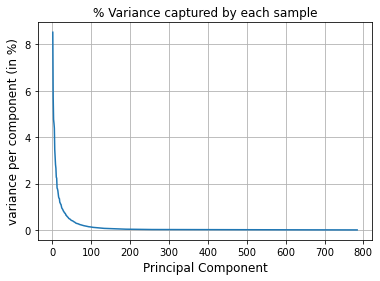

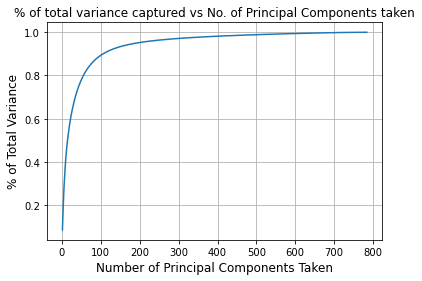

In [22]:
#deciding number of Principal components to include
#we first analyse the amount of variance captured by each principal component
pca_comps = 784
pca = PCA(n_components=pca_comps)
pca.fit(X_train)
var = pca.explained_variance_ratio_

plt.plot(np.linspace(1,pca_comps,pca_comps),var*100)
plt.title("% Variance captured by each sample")
plt.xlabel("Principal Component",fontsize=12)
plt.ylabel("variance per component (in %)",fontsize=12)
plt.grid(True)
plt.show()

#we now analyse the amount of total variance captured as we increase the no of principal components...essentially the integral/sum of previous graph
var_int = np.empty(len(var))
var_int[0] = var[0]
for i in range(1,len(var)):
    var_int[i] = var_int[i-1] + var[i] 
    
plt.plot(np.linspace(1,pca_comps,pca_comps),var_int)
plt.title("% of total variance captured vs No. of Principal Components taken")
plt.xlabel("Number of Principal Components Taken",fontsize=12)
plt.ylabel("% of Total Variance",fontsize=12)
plt.grid(True)
plt.show()
    

In [23]:
#we decide to go with 100 principal components, it captures about 89% of the total variance.
# it is a good trade-off between amt of variance captured and the computation time required.
n_comps = 100
pca = PCA(n_components=n_comps)
pca.fit(X_train)

#save the PCA model as a pickle file to be used later. uncommwnt to update model

#pickle.dump(pca,open('pca_100','wb'))

X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)
var = pca.explained_variance_ratio_

In [24]:
print('{}% of the total variance is captured by {} components.'.format(np.sum(var)*100,n_comps))

89.34824426182567% of the total variance is captured by 100 components.


In [25]:
#splitting into train and validation sets to validate our models.
X_tr,X_val,Y_tr,Y_val = train_test_split(X_train_new,Y_train,test_size=0.2)

### Models that performed well 
1) SVM 'rbf'

2) SVM 'poly'

3) KNN

4) Ensemble of the above three models

### 1) SVM 'rbf'

In [26]:
#Hyperparamter tuning for gamma
gamma_1 = np.array([2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4])*1e-07
SVM_rbf_acc = np.empty(len(gamma_1))
for i in range(len(gamma_1)):
    SVM_clf_rbf = svm.SVC(kernel = 'rbf',gamma=gamma_1[i],class_weight='balanced',break_ties=True)
    SVM_rbf_acc[i] = np.mean(cross_val_score(SVM_clf_rbf, X_train_new, Y_train, cv=3))

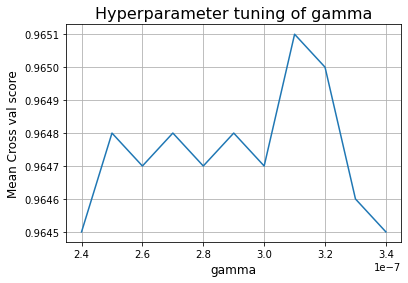

In [27]:
plt.plot(gamma_1,SVM_rbf_acc)
plt.title("Hyperparameter tuning of gamma",fontsize=16)
plt.xlabel("gamma",fontsize=12)
plt.ylabel("Mean Cross val score",fontsize=12)
plt.grid(True)
plt.show()

#### We choose gamma = 3.1e-07 as the hyperparameter

In [28]:
#hyperparameter tuning for C(regularisation parameter)
Cs = np.array([0.5,1,2,3,4])
SVM_rbf_acc2 = np.empty(len(Cs))
for i in range(len(Cs)):
    SVM_clf_rbf_opt = svm.SVC(kernel = 'rbf',gamma=3.1e-07,C=Cs[i],class_weight='balanced',break_ties=True)
    SVM_rbf_acc2[i] = np.mean(cross_val_score(SVM_clf_rbf_opt, X_train_new, Y_train, cv=3))

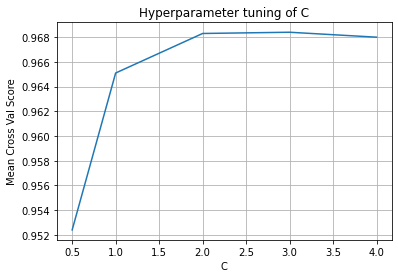

In [29]:
plt.plot(Cs,SVM_rbf_acc2)
plt.title("Hyperparameter tuning of C")
plt.xlabel("C")
plt.ylabel("Mean Cross Val Score")
plt.grid(True)
plt.show()

#### We choose C = 2 as the hyperparameter

In [30]:
SVM_rbf_opt = svm.SVC(kernel = 'rbf',gamma=3.2e-07,C=2,class_weight='balanced',break_ties=True)
SVM_rbf_opt.fit(X_tr,Y_tr)
print("train accuracy for SVM rbf: {}".format(SVM_rbf_opt.score(X_tr,Y_tr)))
print("validation accuracy for SVM rbf: {}".format(SVM_rbf_opt.score(X_val,Y_val)))

train accuracy for SVM rbf: 0.999875
validation accuracy for SVM rbf: 0.9655


### 2) SVM 'poly' 

In [31]:
# finding the optimal value of degree of polynomial kernel
svm_poly_acc = np.empty(9)
deg = np.arange(1,10)
for i in range(9):
    SVM_clf_polyd = svm.SVC(kernel = 'poly',degree = deg[i])
    svm_poly_acc[i]  = np.mean(cross_val_score(SVM_clf_polyd, X_train_new, Y_train, cv=3))
     

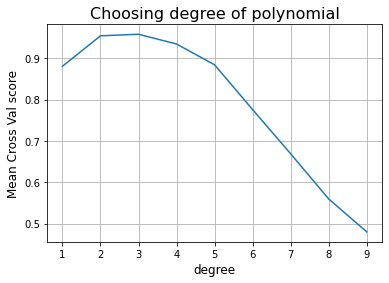

In [32]:
plt.plot(deg,svm_poly_acc)
plt.title("Choosing degree of polynomial",fontsize=16)
plt.xlabel("degree",fontsize=12)
plt.ylabel("Mean Cross Val score",fontsize=12)
plt.grid(True)
plt.show()

#### We choose degree = 3 as the hyperparameter 

In [36]:
# finding the optimal value of degree of polynomial kernel
SVM_poly_acc = np.empty(9)
gamma_2 = np.array([1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5])*1e-07

for i in range(9):
    SVM_clf_polyd = svm.SVC(kernel = 'poly',gamma = gamma_2[i])
    svm_poly_acc[i]  = np.mean(cross_val_score(SVM_clf_polyd, X_train_new, Y_train, cv=3))

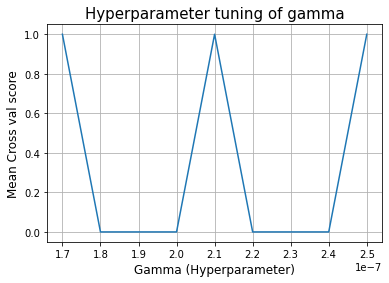

In [37]:
#Hyperparamter tuning for gamma 
plt.plot(gamma_2,SVM_poly_acc)
plt.title("Hyperparameter tuning of gamma",fontsize=15)
plt.xlabel("Gamma (Hyperparameter)",fontsize=12)
plt.ylabel("Mean Cross val score",fontsize=12)
plt.grid(True)
plt.show()

#### We choose gamma =  2.1e-07 as the hyperparameter

In [38]:
SVM_poly_opt = svm.SVC(kernel = 'poly',degree = 3,gamma = 2.1e-07,class_weight = 'balanced',break_ties=True)
SVM_poly_opt.fit(X_tr,Y_tr)
print("train accuracy for SVM poly: {}".format(SVM_poly_opt.score(X_tr,Y_tr)))
print("validation accuracy for SVM poly: {}".format(SVM_poly_opt.score(X_val,Y_val)))

train accuracy for SVM poly: 0.998875
validation accuracy for SVM poly: 0.959


### 3) KNN

In [43]:
# finding the optimal value of 'k' nearest neigbours
k = np.linspace(1,27,14)
knn_acc = np.empty(14)
for i in range(len(k)):
    KNN = KNeighborsClassifier(n_neighbors=int(k[i]),weights='distance')
    knn_acc[i] = np.mean(cross_val_score(KNN,X_train_new,Y_train))

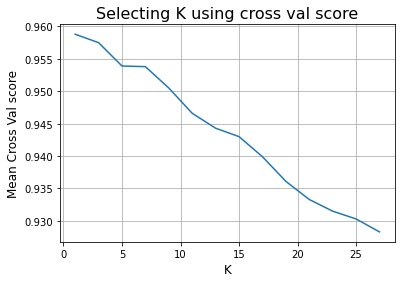

In [44]:
plt.plot(k,knn_acc)
plt.title('Selecting K using cross val score',fontsize=16)
plt.xlabel("K",fontsize=12)
plt.ylabel('Mean Cross Val score',fontsize=12)
plt.grid(True)

#### We choose K=3 as the hyperparameter, as K=1 may lead to high variance

In [45]:
KNN = KNeighborsClassifier(n_neighbors=3,weights='distance')
KNN.fit(X_tr,Y_tr)
print("train accuracy for KNN: {}".format(KNN.score(X_tr,Y_tr)))
print("validation accuracy for KNN: {}".format(KNN.score(X_val,Y_val)))

train accuracy for KNN: 1.0
validation accuracy for KNN: 0.957


### 4) VOTING ENSEMBLE OF THE THREE MODELS:

In [46]:
#all the tuned individual models
SVM_1 = svm.SVC(kernel = 'rbf',gamma=3.1e-07,class_weight='balanced',C=2,break_ties=True,probability=True)
SVM_2 = svm.SVC(kernel = 'poly',degree = 3,gamma=2.1e-07,class_weight='balanced',break_ties=True,probability=True)
KNN_1 = KNeighborsClassifier(n_neighbors=3,weights='distance')


In [47]:
#Ensemble Voting Classifier
clf_en = VotingClassifier(estimators=[('rbf', SVM_1), ('poly', SVM_2), ('knn', KNN_1)], voting='soft',weights=[1,1,1])

In [48]:
clf_en.fit(X_train_new,Y_train)

VotingClassifier(estimators=[('rbf',
                              SVC(C=2, break_ties=True, class_weight='balanced',
                                  gamma=3.1e-07, probability=True)),
                             ('poly',
                              SVC(break_ties=True, class_weight='balanced',
                                  gamma=2.1e-07, kernel='poly',
                                  probability=True)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=3,
                                                   weights='distance'))],
                 voting='soft', weights=[1, 1, 1])

In [49]:
pred_public = clf_en.predict(X_test_new).reshape(-1,1)

In [ ]:
#uncomment to update model
#pickle.dump(clf_en,open('ensemble_model','wb'))

### PREDICT_PRIVATE_DATASET: 

In [51]:
def predict_private_dataset():
    
    #loads private data
    private_test = pd.read_csv("private_test.csv",header=None).to_numpy()
    private_test = private_test.transpose()                             #these step is to accomodate the condition that each image is saved as a col.
    for i in range(len(private_test)):
        private_test[i] = private_test[i].reshape(28,28).transpose().flatten()
    X_pri = private_test.copy()
        
    #applying PCA on private test data
    pca_loaded = pickle.load(open('pca_100','rb'))
    X_pri_new = pca_loaded.transform(X_pri)
    
    #loads data from pickle file
    model = pickle.load(open('ensemble_model','rb'))
    
    #predicting labels
    predicted_class = model.predict(X_pri_new).reshape(-1,1)
    
    return predicted_class

### Models that didn't perform well: 
 We have just included the best possible performance given by each model after hyperparameter tuning.

In [52]:
GNB = GaussianNB()
GNB.fit(X_tr,Y_tr)
print("train accuracy for Gaussian Naive Bayes: {}".format(GNB.score(X_tr,Y_tr)))
print("validation accuracy for Gaussian Naive Bayes: {}".format(GNB.score(X_val,Y_val)))

train accuracy for Gaussian Naive Bayes: 0.8195
validation accuracy for Gaussian Naive Bayes: 0.7885


In [53]:
RF = RandomForestClassifier(n_estimators=100,max_depth=11,bootstrap=True,criterion='entropy',ccp_alpha=0.0004,class_weight='balanced_subsample')
RF.fit(X_tr,Y_tr)
print("train accuracy for Random Forest: {}".format(RF.score(X_tr,Y_tr)))
print("validation accuracy for Random Forest: {}".format(RF.score(X_val,Y_val)))

train accuracy for Random Forest: 0.9995
validation accuracy for Random Forest: 0.864


In [54]:
SVM_clf_sig = svm.SVC(kernel = 'sigmoid',gamma=3e-08)
SVM_clf_sig.fit(X_tr,Y_tr),
print("train accuracy for SVM sigmoid: {}".format(SVM_clf_sig.score(X_tr,Y_tr)))
print("validation accuracy for SVM sigmoid: {}".format(SVM_clf_sig.score(X_val,Y_val)))

train accuracy for SVM sigmoid: 0.879
validation accuracy for SVM sigmoid: 0.854


In [55]:
LogReg = LogisticRegression(penalty = 'l2', max_iter = 10000,solver = 'saga')
LogReg.fit(X_tr,Y_tr)
print("train accuracy for Logistic Regression: {}".format(LogReg.score(X_tr,Y_tr)))
print("validation accuracy for Logistic Regression: {}".format(LogReg.score(X_val,Y_val)))

train accuracy for Logistic Regression: 0.869625
validation accuracy for Logistic Regression: 0.8215


Scores printed in the notebook may vary from contest scores due to random_state inside classifiers and splitting of data